This notebook is used to perform inverse modeling or parameter estimation of CANOAK.

# Load the necessary libraries

In [6]:
# # TODO: A more generic way is needed here to load the path
# import sys

# sys.path.append(
#     "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
#     # "/global/homes/p/peishi89/jax-watershed/src"
# )

In [24]:
# from functools import partial

import numpy as np

import jax
import jax.numpy as jnp
import jax.tree_util as jtu

import equinox as eqx
import optax

from jax_canoak.subjects import get_met_forcings, initialize_parameters, Obs
from jax_canoak.physics.energy_fluxes import get_dispersion_matrix
from jax_canoak.models import CanoakBase
from jax_canoak.shared_utilities.optim import perform_optimization

import matplotlib.pyplot as plt
from jax_canoak.shared_utilities.plot import (
    plot_daily,
    plot_timeseries,
    plot_timeseries_obs_1to1,
)
from jax_canoak.shared_utilities.plot import (
    plot_obs_1to1,
    plot_obs_comparison,
    plot_obs_energy_closure,
)

# from jax_canoak.shared_utilities.plot import plot_veg_temp, plot_dij
# from jax_canoak.shared_utilities.plot import plot_ir, plot_rad, plot_prof2

jax.config.update("jax_enable_x64", True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model parameters and settings

In [8]:
time_zone = -8
latitude = 38.0991538
longitude = -121.49933
stomata = 2
hypo_amphi = 1
veg_ht = 0.8
leafangle = 1
n_can_layers = 50
meas_ht = 5.0
n_hr_per_day = 48
lai = 5.0
niter = 15

f_forcing = "../data/fluxtower/Alf/AlfBouldinMetInput.csv"

# Load and set the model forcings

In [9]:
met, n_time = get_met_forcings(f_forcing, lai)

# Create the model parameter instance

In [12]:
setup, original_para = initialize_parameters(
    time_zone=time_zone,
    latitude=latitude,
    longitude=longitude,
    stomata=stomata,
    veg_ht=veg_ht,
    leafangle=leafangle,
    n_can_layers=n_can_layers,
    meas_ht=meas_ht,
    n_hr_per_day=n_hr_per_day,
    n_time=n_time,
    npart=int(1e6),
    niter=niter,
)

# Generate or read the dispersion matrix

In [13]:
# dij = get_dispersion_matrix(setup, para)
dij = get_dispersion_matrix(setup, original_para, "../data/dij/Dij_Alfalfa.csv")

# The default run
This run uses the parameters used by Dennis which yields reasonablly good result.

In [14]:
canoak_eqx = CanoakBase(original_para, setup, dij)
(
    _,
    prof,
    quantum,
    nir,
    ir,
    rnet,
    qin,
    sun_ang,
    leaf_ang,
    lai,
    sun,
    shade,
    soil,
    veg,
    can,
) = canoak_eqx(met)

array([<Axes: xlabel='Hr', ylabel='Temperature [degK]'>,
       <Axes: xlabel='Hr', ylabel='Energy fluxes [W m-2]'>], dtype=object)

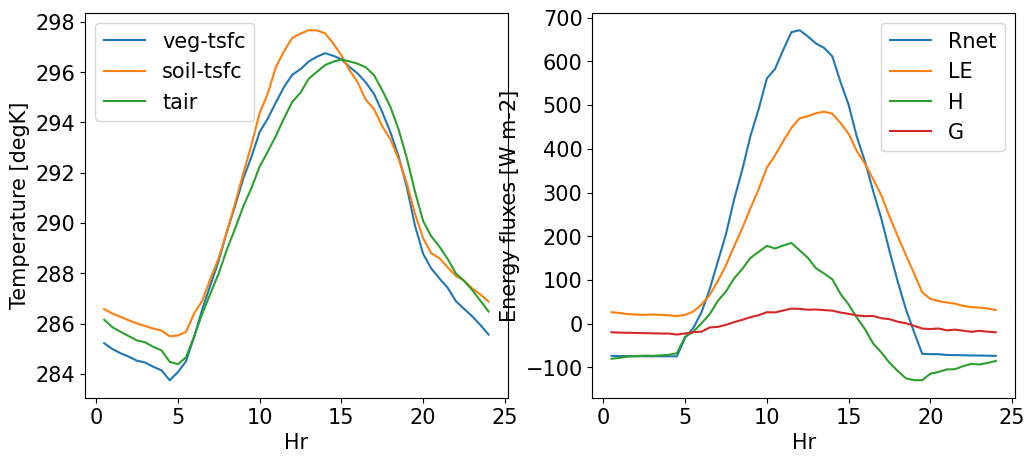

In [15]:
#
plot_daily(met, soil, veg, original_para)

<Axes: title={'center': 'Net radiation [W m-2]'}, xlabel='Time [day of year]'>

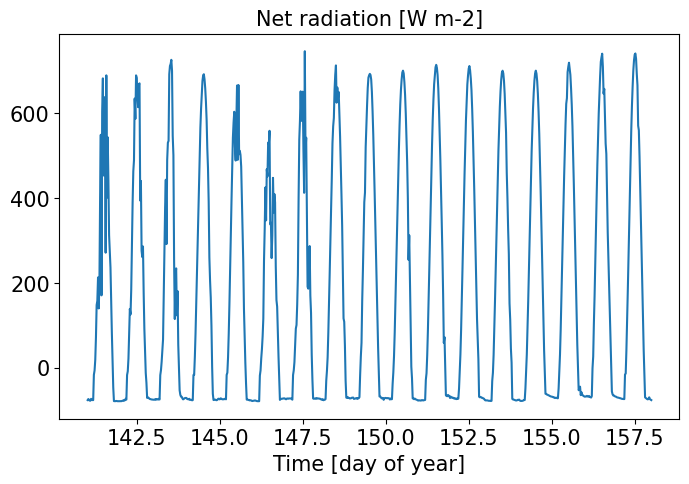

In [23]:
plot_timeseries(
    can.rnet, timesteps=met.day + met.hhour / 24.0, title="Net radiation [W m-2]"
)

# Comparison with observations

In [16]:
# Read the observations
f_obs = "../data/fluxtower/Alf/AlfMetBouldinFluxes.csv"
obs = np.loadtxt(f_obs, delimiter=",")
obs[obs == -9999] = np.nan
obs = jnp.array(obs)

LE_obs, H_obs = obs[:, 2], obs[:, 3]
GPP_obs, Rnet_obs = obs[:, 4], obs[:, 5]
albedo_obs, Fco2_obs = obs[:, 6], obs[:, 7]
Gsoil_obs = obs[:, 8]

obs = Obs(LE_obs, H_obs, GPP_obs, Rnet_obs, albedo_obs, Fco2_obs, Gsoil_obs)

<Axes: xlabel='Rnet, measured', ylabel='H+LE+Gsoil, measured'>

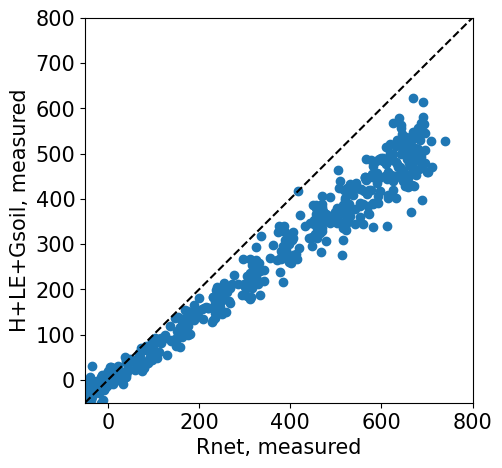

In [17]:
plot_obs_energy_closure(obs)

<Axes: title={'center': 'Rnet (L2: 521.596)'}, xlabel='Measured', ylabel='Simulated'>

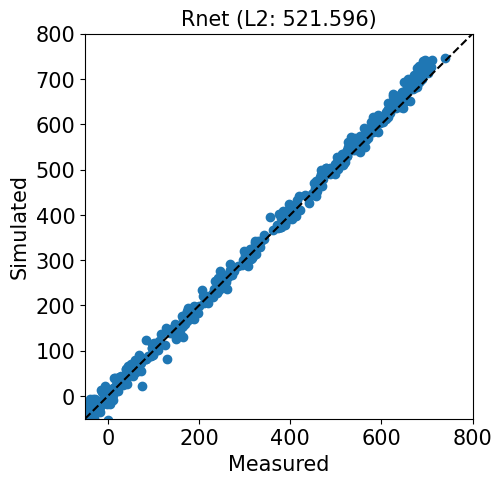

In [38]:
plot_obs_1to1(obs.rnet, can.rnet, lim=[-50, 800], varn="Rnet")

[<Axes: title={'center': 'Net radiation [W m-2]'}, xlabel='Time [day of year]'>,
 <Axes: title={'center': 'varn (L2: 521.596)'}, xlabel='Measured', ylabel='Simulated'>]

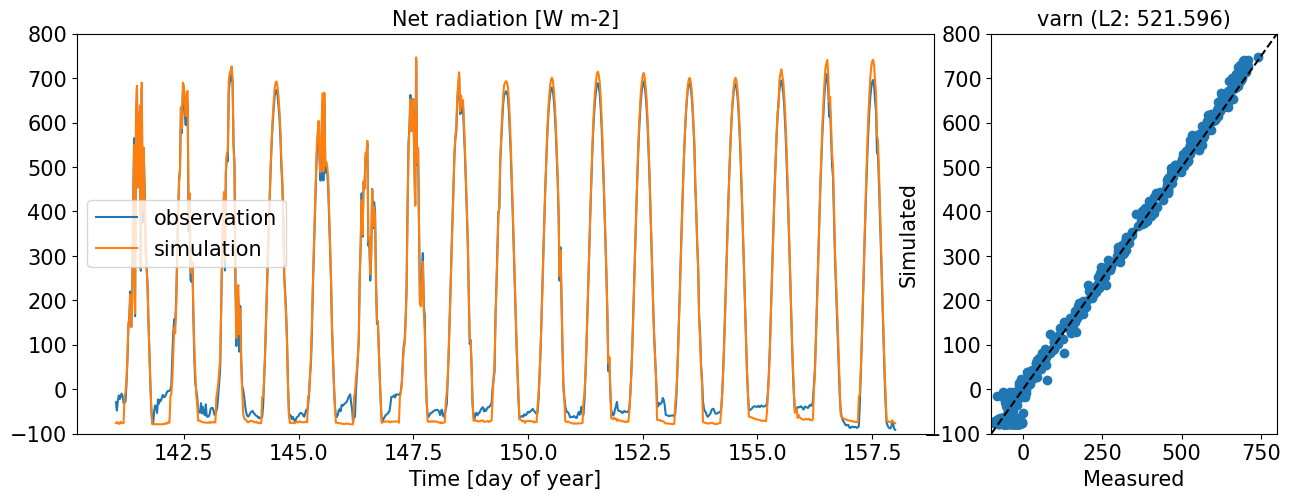

In [37]:
plot_timeseries_obs_1to1(
    obs.rnet,
    can.rnet,
    lim=[-100, 800],
    timesteps=met.day + met.hhour / 24,
    varn="Net radiation [W m-2]",
)

array([[<Axes: title={'center': 'LE (L2: 5372.665)'}, xlabel='Measured', ylabel='Simulated'>,
        <Axes: title={'center': 'H (L2: 6148.875)'}, xlabel='Measured', ylabel='Simulated'>],
       [<Axes: title={'center': 'Rnet (L2: 521.596)'}, xlabel='Measured', ylabel='Simulated'>,
        <Axes: title={'center': 'Gsoil (L2: 107.811)'}, xlabel='Measured', ylabel='Simulated'>]],
      dtype=object)

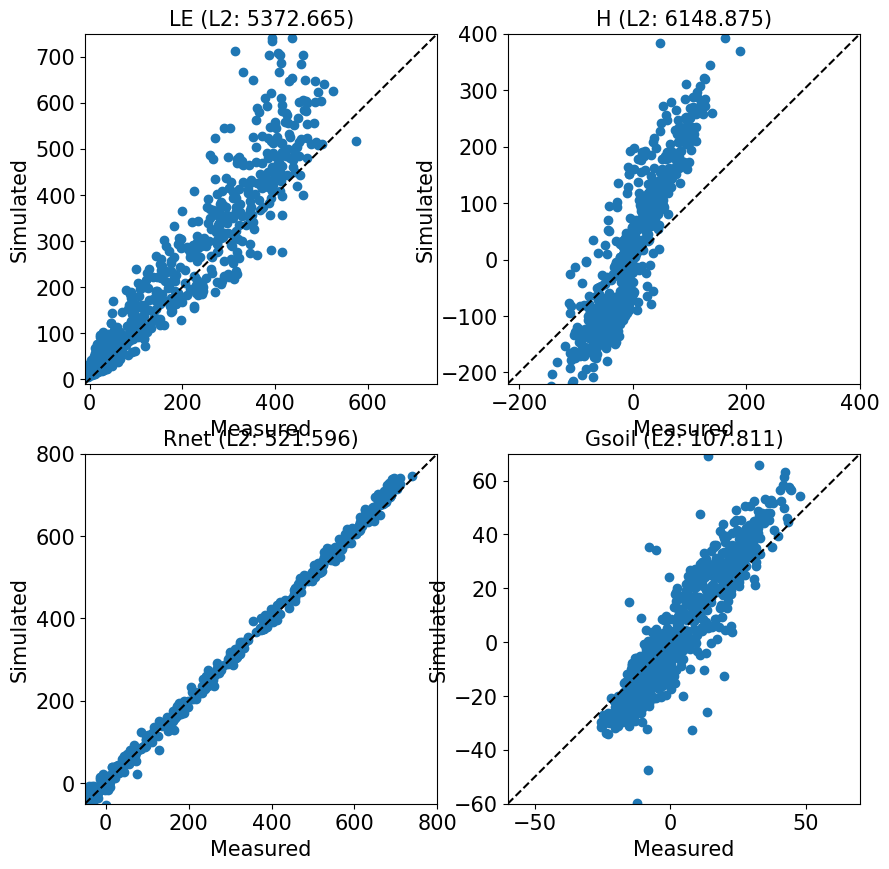

In [18]:
plot_obs_comparison(obs, can)

# Tune the parameter a bit and rerun the model

Here, I change the PAR reflectance ratio from 0.05 to 0.4 so that the model is not able to capture the net radiation that well.

So, 0.4 will be the initial guess of PAR reflectance.

In [39]:
tuned_para = eqx.tree_at(lambda t: t.par_reflect, original_para, jnp.array(0.4))
canoak_eqx_tuned = CanoakBase(tuned_para, setup, dij)

In [40]:
(
    _,
    prof,
    quantum,
    nir,
    ir,
    rnet,
    qin,
    sun_ang,
    leaf_ang,
    lai,
    sun,
    shade,
    soil,
    veg,
    can,
) = canoak_eqx_tuned(met)

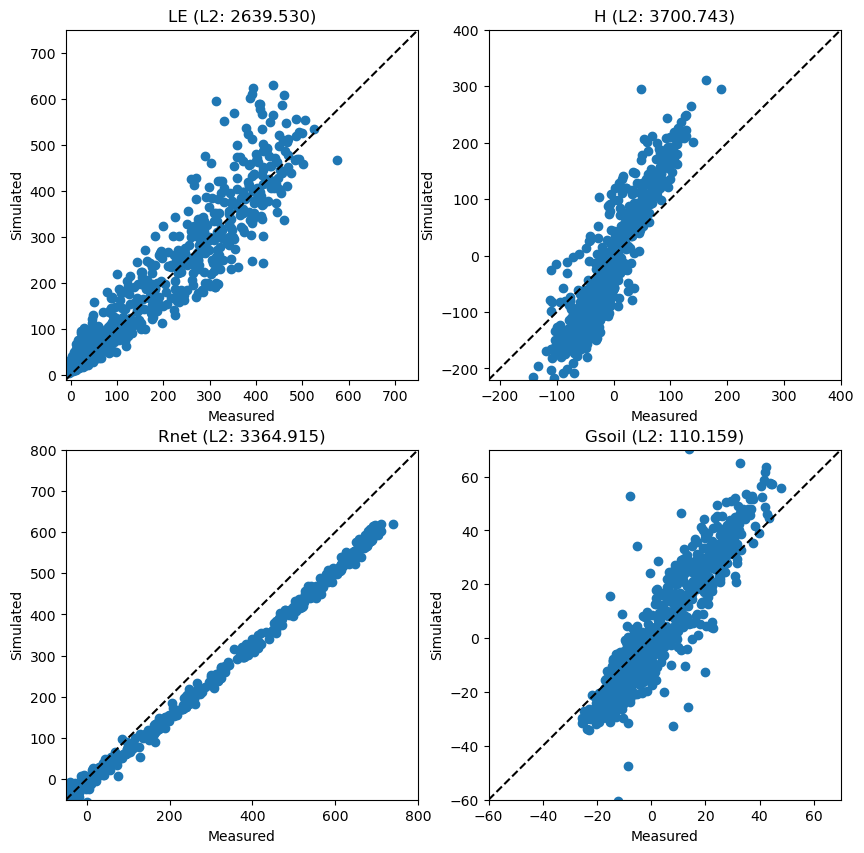

In [14]:
plot_obs_comparison(obs, can)

# Inverse modeling

Now, we calibrate the model against the observed net radiation. To do that, we need to create a new class that only outputs canopy net radiation.

## Create a new class outputing net radiation only

In [18]:
# class CanoakRnet(CanoakBase):
#     @eqx.filter_jit
#     def __call__(self, met):
#         results = super().__call__(met)
#         return results[-1].rnet


# canoak_rnet = CanoakRnet(tuned_para, setup, dij)

In [41]:
can_rnet = canoak_eqx_tuned.get_can_rnet(met)

<Axes: title={'center': 'Rnet (L2: 3364.915)'}, xlabel='Measured', ylabel='Simulated'>

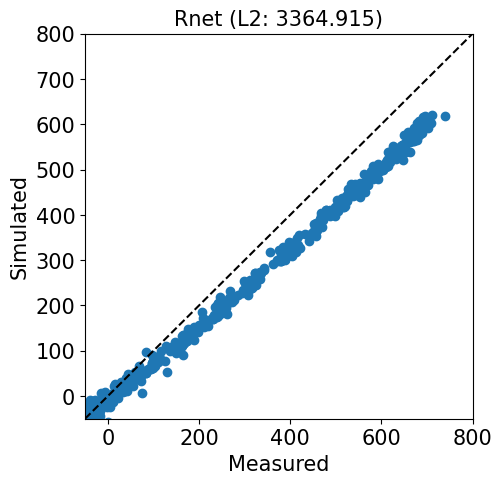

In [42]:
plot_obs_1to1(obs.rnet, can_rnet, lim=[-50, 800], varn="Rnet")

## Perform the parameter estimation

In [43]:
# Filter the parameters to be estimated
filter_model_spec = jtu.tree_map(lambda _: False, canoak_eqx_tuned)
filter_model_spec = eqx.tree_at(
    lambda t: (t.para.par_reflect),
    filter_model_spec,
    replace=(True),
)

In [44]:
nsteps = 100  # number of epoches
y = obs.rnet  # observations
optim = optax.adam(learning_rate=0.01)  # Adam optimizer
canoak_eqx_new, loss_set = perform_optimization(
    canoak_eqx_tuned.get_can_rnet, filter_model_spec.get_can_rnet, optim, y, met, nsteps
)
canoak_eqx_new = canoak_eqx_new.args[0]

The loss of step 0: 3364.9151292019346
The loss of step 1: 3155.3299728924676
The loss of step 2: 2955.6887905753356
The loss of step 3: 2765.9086308755222
The loss of step 4: 2585.8524508246965
The loss of step 5: 2415.399519502537
The loss of step 6: 2254.3603682058274
The loss of step 7: 2102.545804446955
The loss of step 8: 1959.726547075291
The loss of step 9: 1825.6947217588706
The loss of step 10: 1700.2074220961915
The loss of step 11: 1583.0241852567942
The loss of step 12: 1473.8561447789218
The loss of step 13: 1372.4274873254017
The loss of step 14: 1278.4667646170224
The loss of step 15: 1191.7299219615606
The loss of step 16: 1111.7205138994168
The loss of step 17: 1038.303330239738
The loss of step 18: 971.1091699800014
The loss of step 19: 909.8342172111828
The loss of step 20: 854.1694439911478
The loss of step 21: 803.8104091637773
The loss of step 22: 758.836522526108
The loss of step 23: 718.1600601415361
The loss of step 24: 681.4315442920787
The loss of step 25: 6

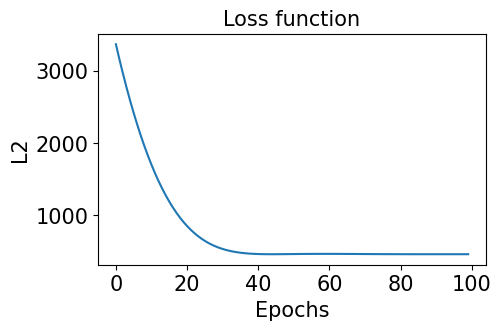

In [45]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(loss_set)
ax.set(xlabel="Epochs", ylabel="L2", title="Loss function", yscale="linear");

## Rerun the model using the estimated parameters
The new model yields rnet with lower L2!

<Axes: title={'center': 'Rnet (L2: 464.886)'}, xlabel='Measured', ylabel='Simulated'>

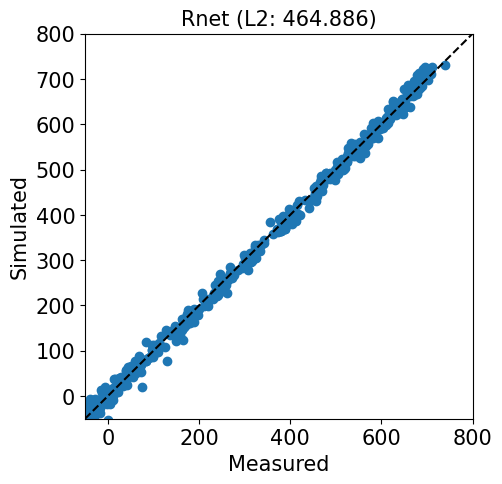

In [46]:
# Run
can_rnet_new = canoak_eqx_new.get_can_rnet(met)
plot_obs_1to1(obs.rnet, can_rnet_new, lim=[-50, 800], varn="Rnet")

In [ ]:
# canoak_new

# Backup

In [25]:
# # Define the loss function
# # @eqx.filter_grad
# @eqx.filter_value_and_grad
# def loss_func(diff_model, static_model, y, met):
#     # jax.debug.print("par_reflect: {x}", x=diff_para.par_reflect)
#     model = eqx.combine(diff_model, static_model)
#     results = model(met)
#     can = results[-1]
#     pred_y = can.rnet
#     return jnp.mean((y-pred_y)**2)

# @eqx.filter_jit
# def make_step(model, filter_model_spec, y, opt_state, met):
#     diff_model, static_model = eqx.partition(model, filter_model_spec)
#     loss, grads = loss_func(diff_model, static_model, y, met)
#     updates, opt_state = optim.update(grads, opt_state)
#     model = eqx.apply_updates(model, updates)
#     return model, opt_state, loss, grads

In [71]:
# # Perform optimization
# nsteps = 100
# y = obs.rnet
# new_model = canoak_eqx_tuned
# loss_set = []
# # Create the optimization object
# optim = optax.adam(learning_rate=0.01)
# opt_state = optim.init(new_model)
# # Optimizing...
# for i in range(nsteps):
#     new_model, opt_state, loss, grads = make_step(new_model,
#           filter_model_spec, y, opt_state, met)
#     loss_set.append(loss)
#     print(f'The loss of step {i}: {loss}')
#     print('par_reflect:{}'.format(new_model.para.par_reflect))

In [28]:
# # Check the result
# (
#     _,
#     prof,
#     quantum,
#     nir,
#     ir,
#     rnet,
#     qin,
#     sun_ang,
#     leaf_ang,
#     lai,
#     sun,
#     shade,
#     soil,
#     veg,
#     can
# ) = new_model(met)

In [64]:
# fig, ax = plt.subplots(1, 1, figsize=(5,3))
# ax.plot(loss_set)
# ax.set(xlabel='Epochs', ylabel='L2', title='Loss function', yscale='linear');

In [66]:
# plot_obs_comparison(obs, can)

In [67]:
# # Filter the parameters to be estimated
# filter_para_spec = jtu.tree_map(lambda _: False, tuned_para)
# filter_para_spec = eqx.tree_at(
#     # lambda t: (t.leaf_clumping_factor, t.par_reflect, t.nir_reflect, t.epsoil),
#     # filter_para_spec,
#     # replace=(True, True, True, True),
#     lambda t: (t.par_reflect),
#     filter_para_spec,
#     replace=(True),
# )
# # diff_para, static_para = eqx.partition(tuned_para, filter_para_spec)

In [61]:
# (TODO) Filter the output to be compared

In [68]:
# # Define the loss function
# # @eqx.filter_grad
# @eqx.filter_value_and_grad
# def loss_func(diff_para, static_para, y, met, **kwargs):
#     # jax.debug.print("par_reflect: {x}", x=diff_para.par_reflect)
#     para_eqx = eqx.combine(diff_para, static_para)
#     results = canoak(para=para_eqx, met=met, **kwargs)
#     can = results[-1]
#     pred_y = can.rnet
#     return jnp.mean((y-pred_y)**2)

# @eqx.filter_jit
# def make_step(para, filter_para_spec, y, opt_state, met, **kwargs):
#     diff_para, static_para = eqx.partition(para, filter_para_spec)
#     loss, grads = loss_func(diff_para, static_para, y, met, **kwargs)
#     updates, opt_state = optim.update(grads, opt_state)
#     para = eqx.apply_updates(para, updates)
#     return para, opt_state, loss, grads

In [69]:
# # Perform optimization
# # gradients = loss(diff_para, static_para, setup, met, obs.gsoil, *other_args)
# nsteps = 100
# y = obs.rnet
# new_para= tuned_para
# loss_set = []
# # Create the optimization object
# optim = optax.adam(learning_rate=0.01)
# opt_state = optim.init(new_para)
# # Optimizing...
# for i in range(nsteps):
#     new_para, opt_state, loss, grads = make_step(new_para,
#         filter_para_spec, y, opt_state, met, **kwargs)
#     loss_set.append(loss)
#     print(f'The loss of step {i}: {loss}')
#     print('par_reflect:{}'.format(new_para.par_reflect))

In [70]:
# # Check the result
# (
#     _,
#     prof,
#     quantum,
#     nir,
#     ir,
#     rnet,
#     qin,
#     sun_ang,
#     leaf_ang,
#     lai,
#     sun,
#     shade,
#     soil,
#     veg,
#     can
# ) = canoak_jit(para=new_para, met=met, **kwargs)